#### 2024/05/28 宮崎聡 (ハワイ観測所)

### 課題1：2024/03/19にLCUのひとつである、MCUのトラブルのTSCデータを調査せよ  （SciOps Night Log - 2024-03-19を参照せよ）課題2 : 課題1のLCU(MCU)データを確認し、ログデータから原因を考察せよ


In [264]:
import subprocess
from subprocess import PIPE

def shell(command):
#    print(command)
    proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
    return proc.stdout, proc.stderr

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime

def split_list(lst, chunk_size):
    """
    リストをサブリストに分割する
    :param lst: リスト
    :param chunk_size: サブリストの要素数
    :return: 
    """
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

#### データ切り出し

In [259]:
extractor = "dump-tsc-log -a -z"
inputFilePath = "/stars/2024/TSCV-20240319-17.pkt"
#outputFilePath = os.path.basename(inputFilePath) + "-E-0002.log"

names = ["AZ DPA-1A Alarm",
         "AZ DPA-1B Alarm",
         "AZ DPA-2A Alarm",
         "AZ DPA-2B Alarm",
         "EL DPA-1A Alarm",
         "EL DPA-1B Alarm",
         "EL DPA-2A Alarm",
         "EL DPA-2B Alarm"
        ]
extractNames = f''
for name in names:
    extractNames += f'-e \"{name}\" '

(_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')
outputFilePath = outputText.split('\n')[-2][11:]

print(f'{outputFilePath} generated.')

./TSCV-20240319-17.pkt-E-0002.log generated.


#### outliers検出方法の定義

In [260]:
def byPercentile(ts, cut):
    l = np.percentile(ts, cut)
    h = np.percentile(ts, 100-cut)
    return ts[(ts > h) | (ts < l)]

def byMovingMean(ts, window, cut):
    moving_average = ts.rolling(window=window).mean()

    # 差分を計算
    diff = ts - moving_average

    # 外れ値を検出（ここでは差分が標準偏差の3倍を超えるものを外れ値とする）
    threshold = cut * diff.std()
    return ts[np.abs(diff) > threshold]

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def byExponentialSmoothing(ts):
    # エクスポネンシャルスムージングを適用
    model = ExponentialSmoothing(ts, trend='add', seasonal=None)
    fit = model.fit(smoothing_level=0.8, optimized=False)
    smoothed = fit.fittedvalues

    # 差分を計算
    diff = ts - smoothed

    # 外れ値を検出（ここでは差分が標準偏差の3倍を超えるものを外れ値とする）
    threshold = 3 * diff.std()
    return ts[np.abs(diff) > threshold]

def byPctChange(ts, cut):
    returns = ts.pct_change()

    # 外れ値を検出（ここでは変動率が標準偏差の3倍を超えるものを外れ値とする）
    threshold = cut * returns.std()
    return ts[np.abs(returns) > threshold]



#### 外れ値を検出

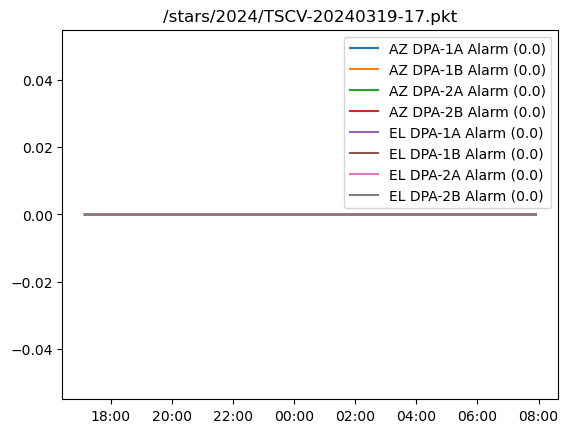

In [261]:
df = pd.read_table(outputFilePath)
data = df.values
df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for i, name in zip(range(3, 3+len(names)), names):
    ts = pd.Series(data[:,i], index=df['datetime'])

    outliers = byPercentile(ts, 0.01)
    ax.plot(ts, label=f'{name} ({np.var(data[:,i]):.1f})')
    ax.scatter(outliers.index, outliers, color='orange')

plt.title(inputFilePath)
plt.legend()
plt.show()

#### 状態変化したMCU関係のパラメータを全検索する

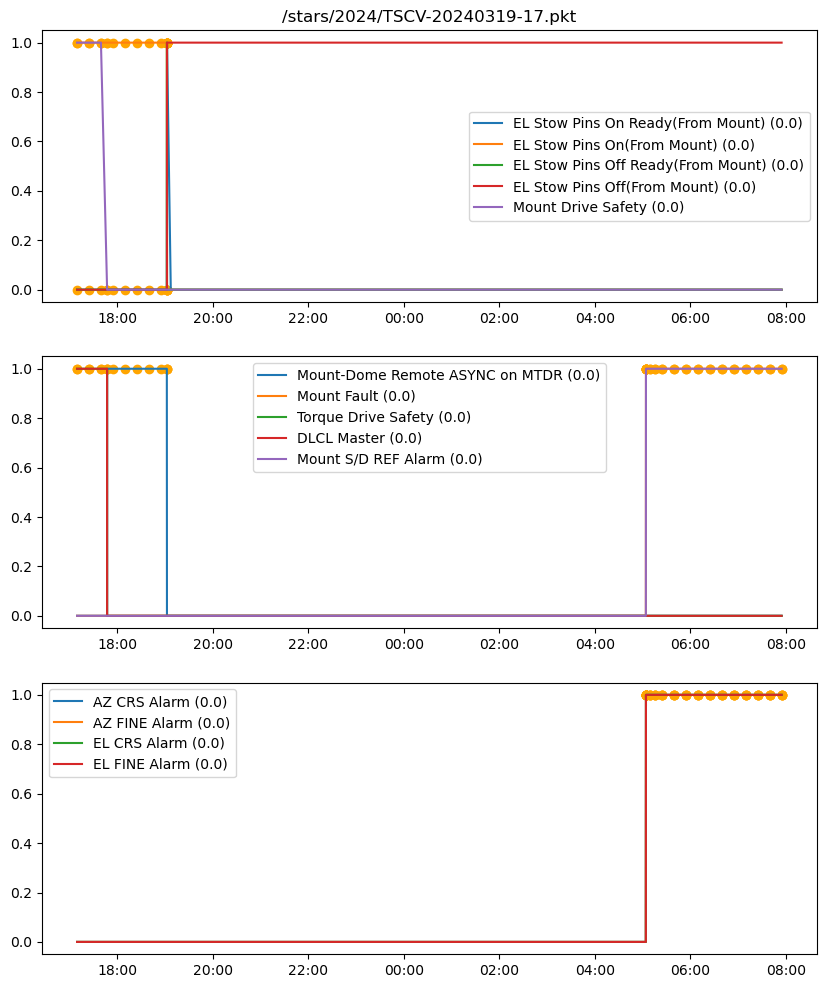

In [297]:
#### 
date = {'year':2024, 'month':3, 'day':19}

type = 'E' # 'E' 'L' 'S'
devName = 'MCU'

numberInChunk = 8   # 一度のextractするデータ数
numberOfSuperimpose = 5  # 1つのグラフに重ね書きするデータ数
isVerbose = False   # show text output

####

df = pd.read_csv('dump-tsc-loghsc.csv', low_memory=False)
data = df.values

indexName = 1
indexType = 3
indexDev = 24

names = []
for d in data:
    if d[indexDev] == devName and d[indexType] == type:
#    if d[dev] == 'MCU' and d[type] == 'L':
#    if d[dev] == 'MCU' and d[type] == 'S':
        names.append(d[indexName])
if isVerbose:
    print(len(names), 'found')
splitNames = split_list(names, numberInChunk)
#print(splitNames)

if type == 'E':
    _type = 'V'
else:
    _type = type
inputFilePath = f"/stars/{date['year']}/TSC{_type}-{date['year']}{date['month']:02}{date['day']:02}-17.pkt"
if isVerbose:
    print(inputFilePath)
#inputFilePath = "/stars/2024/TSCV-20240601-17.pkt"
#outputFilePath = os.path.basename(inputFilePath) + "-E-0002.log"

tss = []
outlierss = []
outlierNames = []

def checkOutliers(names):
    extractNames = f''
    for name in names:
        extractNames += f'-e \"{name}\" '
    (_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')
    outputFilePath = outputText.split('\n')[-2][11:]
#    print(f'{outputFilePath} generated.')
    
    df = pd.read_table(outputFilePath)
    data = df.values
    df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])

    for i, name in zip(range(3, 3+len(names)), names):
        ts = pd.Series(data[:,i], index=df['datetime'])
        
        outliers = byPercentile(ts, 0.1)
#        outliers = byMovingMean(ts, 20, 10)
#        outliers = byPctChange(ts, 3)
        
        if len(outliers) > 0:
            tss.append(ts)
            outlierss.append(outliers)
            outlierNames.append(name)
            
    os.remove(outputFilePath)
            

for _names in splitNames:
    checkOutliers(_names)

if len(outlierss) == 0:
    print("No outlier found")
    sys.exit()

numberOfPlot, rest = divmod(len(outlierss), numberOfSuperimpose)
if rest > 0:
    numberOfPlot += 1


fig, axes = plt.subplots(numberOfPlot, 1, figsize=(10, 4*numberOfPlot))

plt.subplot(numberOfPlot, 1, 1)  # to set the following title only at the top
plt.title(inputFilePath)

plotId = 0
cnt = 0
for ts, outliers, outlierName in zip(tss, outlierss, outlierNames):
    if numberOfPlot == 1:
        _ax = axes
    else:
        _ax = axes[plotId]
    _ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    _ax.plot(ts, label=f'{outlierName} ({np.var(ts):.1f})')
    _ax.scatter(outliers.index, outliers, color='orange')

    if isVerbose:
        for t in outliers.index:
            print(f'{t.strftime("%Y-%m-%d %H:%M:%S.%f")[:21]} {name} : {ts[t]}')
    if (cnt % numberOfSuperimpose == (numberOfSuperimpose-1)) or (cnt == len(outlierss) - 1):
        _ax.legend()
        plotId += 1
    cnt += 1

plt.show()